In [1]:
from typing import TypedDict, Annotated,List
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

In [2]:
load_dotenv()

True

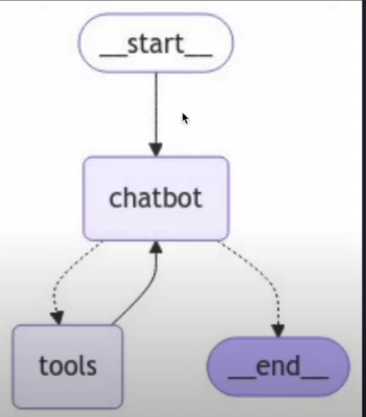

In [3]:
class BasicChatBot(TypedDict):
    messages: Annotated[List, add_messages]

In [4]:
search_tool=TavilySearchResults(max_results=2)

In [5]:
tools=[search_tool]

In [6]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [7]:
llmLlamaWithTools=llmLlama.bind_tools(tools=tools)

In [8]:
# illustrations
llmLlamaWithTools.invoke(input="How is the temperature today at Baranagar, Kolkata?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4wq5', 'function': {'arguments': '{"query": "Baranagar Kolkata temperature today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 579, 'total_tokens': 602, 'completion_time': 0.030666667, 'prompt_time': 0.037695888, 'queue_time': -0.066880408, 'total_time': 0.068362555}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c6d0e18d-d029-4baa-a8bc-f6851929ee1e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Baranagar Kolkata temperature today'}, 'id': 'call_4wq5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 579, 'output_tokens': 23, 'total_tokens': 602})

In [9]:
def chatbot(state:BasicChatBot):
    return {
        "messages":[llmLlamaWithTools.invoke(input=state["messages"])]
    }

In [10]:
tool_node=ToolNode(tools=tools,messages_key="messages")

In [11]:
def tools_router(state:BasicChatBot):
    last_message=state["messages"][-1]

    if hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0:
        return "tool_node"
    else:
        return END

In [12]:
graph=StateGraph(state_schema=BasicChatBot)

In [13]:
graph.add_node(node="chatbot",action=chatbot)

In [14]:
graph.add_node(node="tool_node",action=tool_node)

In [15]:
graph.set_entry_point(key="chatbot")

In [16]:
graph.add_conditional_edges(source="chatbot",path=tools_router)

In [17]:
graph.add_edge(start_key="tool_node",end_key="chatbot")

In [18]:
app=graph.compile()

In [19]:
while True:
    user_input=input("User: ")
    if (user_input in ["exit","end"]):
        break
    else:
        result=app.invoke(input={
            "messages":HumanMessage(content=user_input).content
        })
        print(result)

User:  What's the temperature at Kharagpur, West Bengal?


{'messages': [HumanMessage(content="What's the temperature at Kharagpur, West Bengal?", additional_kwargs={}, response_metadata={}, id='c818ff9a-8b64-4b90-b220-782e47f552da'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wacx', 'function': {'arguments': '{"query": "Kharagpur West Bengal temperature"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 291, 'total_tokens': 315, 'completion_time': 0.032, 'prompt_time': 0.019541316, 'queue_time': 0.196283752, 'total_time': 0.051541316}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-72c3d0b4-93cf-4d9e-846a-402e1adbd691-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kharagpur West Bengal temperature'}, 'id': 'call_wacx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 291, 'output_tokens': 24, 'total_tokens':

User:  end
